## Working With Time Series
I am a newbie to Data Science and have been hooked on Time Series for a while now(actually two weeks!).I was introduced to Fourier Transforms,Exponential Smoothing using moving averages ,ARIMA and from textbooks,I discovered SARIMAX.everytin
At first,everything was confusing but gleaning information from different sources to replicate, modify and start new projects helped me to decipher what was useful.,</br>
Here I am going to model a Time Series using the ***Stattools package***.</br>




## Components of a time series

We can model our time series as having three components,

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

The components are defined as

1. **Drift**: An overall trend present in the time series. An example of a drift model is
$$ y(t) = \mu t. $$
Other commonly applied drift models are quadratic and exponential.

1. **Seasonality**: A periodic behavior existing in the time series. For a given frequency $f$, a common model is
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$

1. **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

In [1]:
from dateutil.parser import parse 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
import numpy as np
import pandas as pd


In [2]:
# load data set
columns = ['year', 'month', 'day', 'decimal date', 'molfrac', 'days', '1 yr ago', '10 yrs ago', 'since 1880']
df = pd.read_csv('data/co2_weekly_mlo.csv', sep='\s+', header=None, names=columns, na_values=-999.99)

# create timestamp indices
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')

# replace missing values
df['molfrac'] = df['molfrac'].fillna(method='ffill')

df.head()


,year,month,day,decimal date,molfrac,days,1 yr ago,10 yrs ago,since 1880
date,,,,,,,,,
1974-05-19,1974,5,19,1974.3795,333.34,6,NaN,NaN,50.36
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974,6,2,1974.4178,332.32,5,NaN,NaN,49.57
1974-06-09,1974,6,9,1974.4370,332.18,7,NaN,NaN,49.63
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.07


In [3]:
#Use the monthly mean averages
y = df['molfrac'].resample('MS').mean()


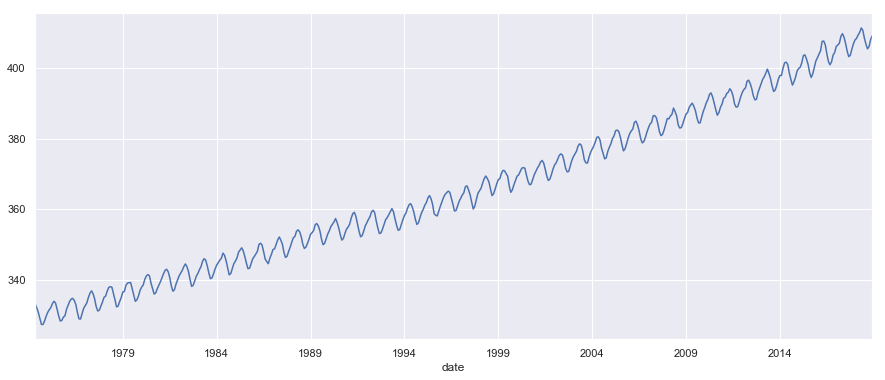

In [4]:
y.plot(figsize=(15, 6))
plt.show()

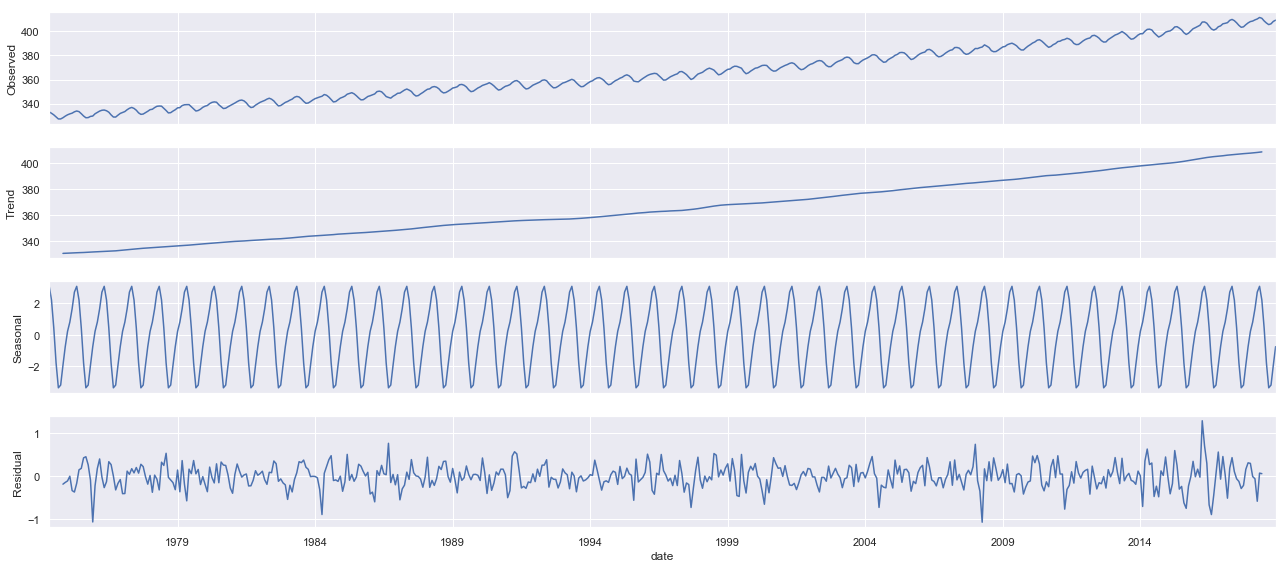

In [5]:
#Use seasonal_decompose to seperate the components of our y namely trend,seasonality and noise using the additive model
from statsmodels.tsa.seasonal import seasonal_decompose as sm

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
Y= sm(y, model='additive')
fig = Y.plot()
plt.show()

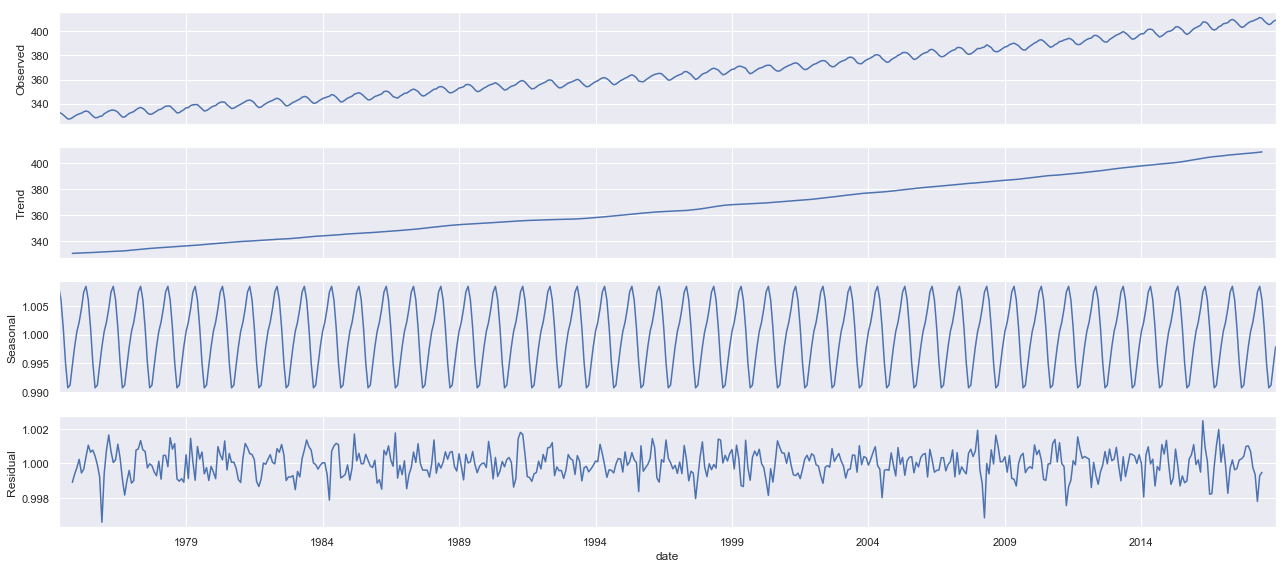

In [6]:
#Use seasonal_decompose to seperate the components of our y namely trend,seasonality and noise using the multiplicative model
from statsmodels.tsa.seasonal import seasonal_decompose as sm

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
M = sm(y, model='multiplicative')
fig = M.plot()
plt.show()

In [7]:
#Use the adfuller test to check if my timeseries y is stationary.

from statsmodels.tsa.stattools import adfuller 
result = adfuller(y, autolag='AIC') 
print('ADF Statistic: %f' %result[0]) 
print('p-value:%f' %result[1]) 
print('CriticalValues:') 
for key,value in result[4].items():
    print('\t%s:%.3f'%(key,value)) 

ADF Statistic: 2.528430
p-value:0.999058
CriticalValues:
	1%:-3.443
	5%:-2.867
	10%:-2.570


Nope! It is not stationary.pvalue is greater than 0.05 and the critical values are less than the ADF Statistic

In [8]:
result1 = adfuller(Y.resid.dropna(),autolag='AIC')
print('ADF Statistic: %f' %result1[0]) 
print('p-value:%f' %result1[1]) 
print('CriticalValues:') 
for key,value in result1[4].items():
    print('\t%s:%.3f'%(key,value)) 

ADF Statistic: -12.386843
p-value:0.000000
CriticalValues:
	1%:-3.443
	5%:-2.867
	10%:-2.570


The reverse is the case here.After seasonal decomposition of the time series y,the residuals(which is the noise) are stationary

In [9]:
result2 = adfuller(M.resid.dropna(),autolag='AIC')
print('ADF Statistic: %f' %result2[0]) 
print('p-value:%f' %result2[1]) 
print('CriticalValues:') 
for key,value in result2[4].items():
    print('\t%s:%.3f'%(key,value)) 

ADF Statistic: -9.779668
p-value:0.000000
CriticalValues:
	1%:-3.443
	5%:-2.867
	10%:-2.570


## SARIMAX MODEL For Forecasting
The difference between ARIMA and SARIMAX is that you can only use ARIMA on stationary models while SARIMAX can be used on both.
The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series. Random-walk and random-trend models, autoregressive models, and exponential smoothing models are all special cases of ARIMA models.

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.

In [10]:
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()

In [11]:
# Did a Grid Search like knowing periodicity is monthly
import itertools
import operator
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()

In [16]:
f = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = mod.fit(disp=False)
            f.append((param,param_seasonal,results.aic))
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print('----------------------------------------------------------------------------------------------------')
print(sorted(f,key=lambda x:x[2]))

C:\Users\user\New folder\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7836.898899549586


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7675.138231917976
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2167.013431984345
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1788.942821842627
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1024.5558760522006
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1022.2584662253137
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1353.255913047556
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:998.6749307898085
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7091.374561351717


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6966.435507180966
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1645.3656235915264
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1451.8409776228345
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:810.0737764864618


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:787.6533192036538
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1183.2484477134963
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:808.7625747245713
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1778.9853371640497
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1322.1445553604385
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:681.5935612467913
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:398.0649535034168
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:669.4267505287505


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:414.42159097636016
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:544.7739356534802
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:400.0651794129167
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1472.5827342481177
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1204.5735169303732
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:591.2151254198038
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:318.78879961619333
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:589.5075518794855
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:332.61230601327713
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:451.68501183170144
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:320.77996519774535
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1777.4370721191287


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1755.8125281793868
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:678.4482981330061
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:399.30235873956985
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:615.2971647488996
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:417.7288375334515
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:544.5255184211907
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:414.0548066339177
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1473.6377480042593


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1467.1033089733053
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:592.2356128114675
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:317.827457362602


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:681.3142588149591


C:\Users\user\New folder\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:430.5685349979124
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:453.5013555343644
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:331.3166467409046
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1422.6253319469492
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1164.541105319517
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:613.9898671797066
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:339.36154157942616
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:607.922097951129
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:355.0029966274826
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:470.1176525926552
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:341.3619188908156
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1361.2127893264194
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1157.3457299245724
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:590.9037245009647
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:318.27305597778513
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:588.5050252435911
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:331.30517218015416
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:453.0474263712309
ARIMA

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0012      0.001   1707.579      0.000       1.000       1.002
ma.L1         -0.4680      0.034    -13.709      0.000      -0.535      -0.401
ma.S.L12      -1.1354      0.031    -37.086      0.000      -1.195      -1.075
sigma2         0.0816      0.006     13.714      0.000       0.070       0.093


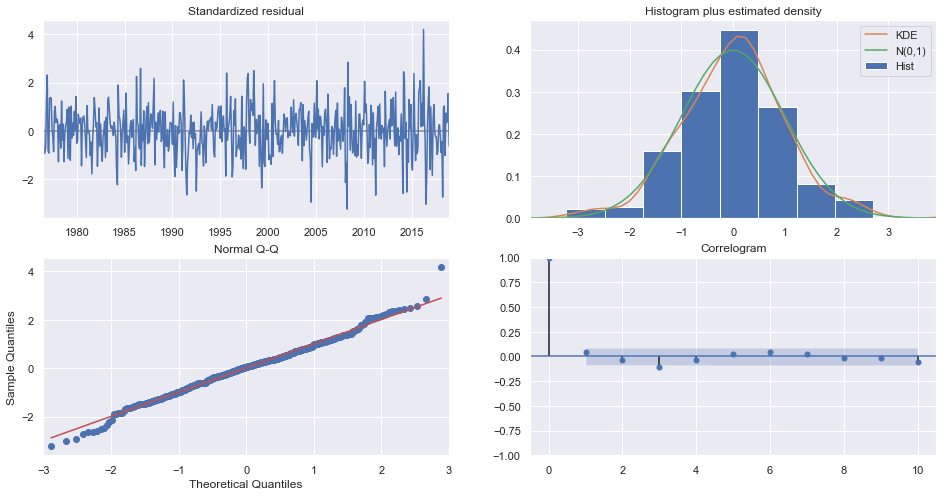

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

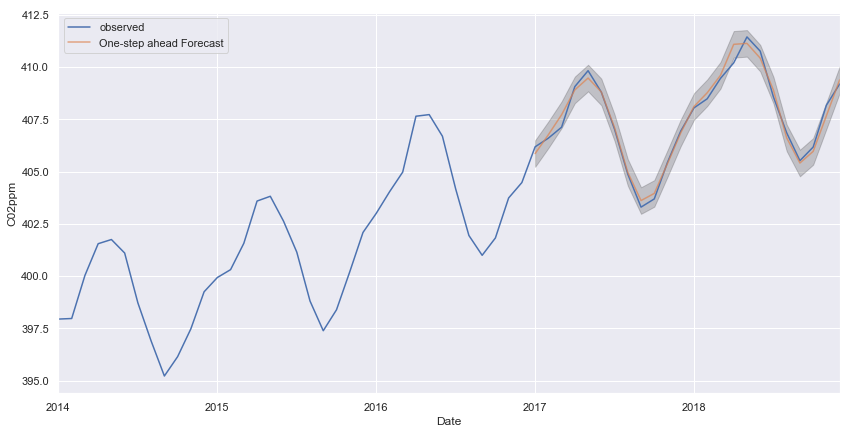

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('C02ppm')
plt.legend()
plt.show()

In [22]:
results.get_prediction?

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.1


In [58]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.32


C:\Users\user\New folder\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


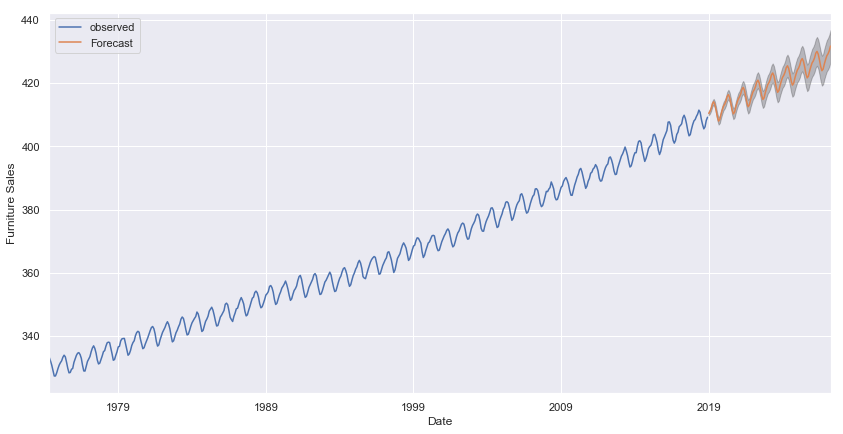

In [59]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()